In [165]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scipy.sparse.linalg 
import scipy
from scipy import sparse
from ECI import *
df = pd.read_csv('./data/country_sitcproduct2digit_year.csv',low_memory=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
year =2017
df_year = df[df['year']==year]
df_year = df_year.drop_duplicates()
df_year = df_year.fillna(0)

In [205]:
df_gdp = pd.read_csv('./data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', sep = '\t')
df_g = df_gdp[['Country Code', str(year)]]
gdp_dict =dict(zip(df_g['Country Code'],df_g[str(year)]))

In [157]:
eci_hidago = df_year[['sitc_eci','location_code']].drop_duplicates()

In [159]:
eci_hidago_dict =dict(zip(eci_hidago['location_code'],eci_hidago['sitc_eci']))

In [109]:
x = list(df_year["location_code"])
y = list(df_year["sitc_product_code"])
data = np.array(list(df_year["export_value"]))
sx = list(set(x))
sy =list(set(y))
dx = dict(zip(sx,range(len(sx))))
dy = dict(zip(sy,range(len(sy))))
x1 = [dx[xi] for xi in x]
y1 = [dy[yi] for yi in y]

In [110]:
# 构建出口矩阵
M = sparse.csc_matrix((data,(x1,y1)),(len(dx),len(dy)))

In [111]:
#计算RCA
R = RCA_sparse(M)

==Time 0.01==


/home/superman/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:597: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/superman/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:597: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/superman/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:208: RuntimeWarning: invalid value encountered in greater_equal
  res = self._with_data(op(self.data, other), copy=True)
/home/superman/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:282: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [112]:
R=R.toarray()
R[np.isnan(R)]=0.0

In [149]:
Mat_Dict = Get_eci_pci(np.matrix(R))
eci,pci = Mat_Dict['eci'],Mat_Dict['pci']

==Time 0.04==


In [166]:
#利用稀疏矩阵计算：
Dict = Get_eci_pci_sparse(sparse.csc_matrix(R))
eci_sparse,pci_sparse = Dict['eci'],Dict['pci']

==Time 0.00==


In [87]:
# 利用ecomplexity计算出来的结果
from ecomplexity import ecomplexity
from ecomplexity import proximity
time = [2017]*len(x)
trade_cols = {'time':'year', 'loc':'name', 'prod':'skill', 'val':'value'}
SData=pd.DataFrame({"year":time,'name':x,"skill":y,"value":data})
cdata = ecomplexity(SData, trade_cols)#使用过滤函数
res=pd.DataFrame({'name':list(cdata.name),"eci":list(cdata.eci)})
res = res.drop_duplicates()

2017


In [194]:
df_year = df[df['year']==year]
trade_cols = {'time':'year', 'loc':'location_code', 'prod':'sitc_product_code', 'val':'export_value'}
cdata2 = ecomplexity(df_year, trade_cols)

2017


In [195]:
res2=pd.DataFrame({'name':list(cdata2.location_code),"eci":list(cdata2.eci)})
res2 = res2.drop_duplicates()

In [212]:
y =[eci[dx[name]] for name in res.name]
y1 = [eci_sparse[dx[name]] for name in res.name]
y2 = [eci_hidago_dict[name] for name in res.name]
gdp = [gdp_dict[name] if name in gdp_dict else 0.0 for name in res.name]

In [213]:
total=pd.DataFrame({'name':list(res.name),'gdp':gdp,'hidago_cal':y2,"hidago_eci":list(res.eci),'eci_mat':y,'eci_sparse':y1})

In [214]:
total.head()

,name,gdp,hidago_cal,hidago_eci,eci_mat,eci_sparse
0,ABW,25630.266490,0.633293,-0.428741,-0.430580,-0.430580
1,AFG,556.302138,-1.237445,-1.080686,-1.083838,-1.083838
2,AGO,4095.812942,-1.822037,-1.478833,-1.482787,-1.482787
3,AIA,0.000000,0.940984,1.044546,1.045672,1.045672
4,ALB,4532.889198,-0.288839,-0.195837,-0.197208,-0.197208


/home/superman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


<Figure size 360x360 with 0 Axes>

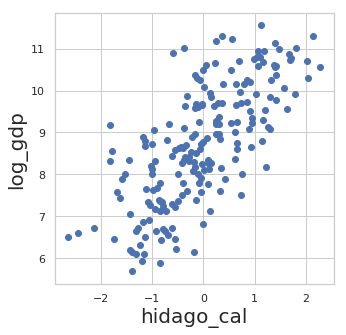

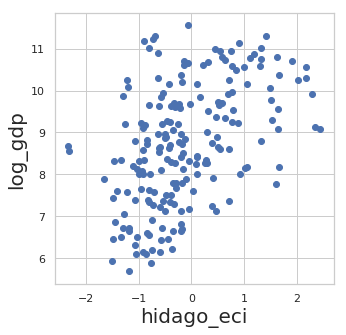

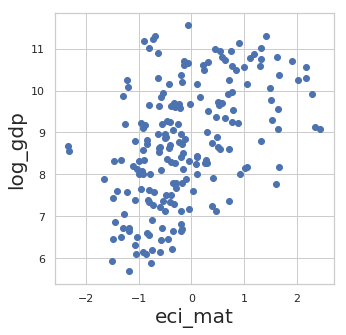

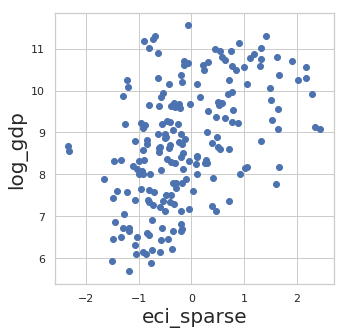

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
sns.set(style="whitegrid")
for key in [ "hidago_cal","hidago_eci","eci_mat","eci_sparse"]:
    plt.figure(figsize=(5,5))
    plt.scatter(total[key],np.log(total['gdp']))
    plt.xlabel(key,fontsize=20)
    plt.ylabel("log_gdp",fontsize=20)

Text(0.5, 0, 'hidago_eci')

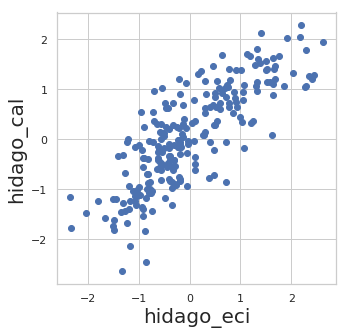

In [239]:
nl = [ "hidago_cal","hidago_eci","eci_mat","eci_sparse"]
plt.figure(figsize=(5,5))
plt.scatter(total[nl[1]],total[nl[0]])
plt.ylabel(nl[0],fontsize=20)
plt.xlabel(nl[1],fontsize=20)

Text(0.5, 0, 'eci_mat')

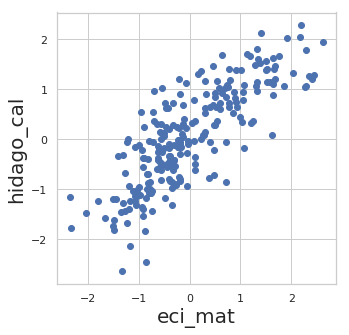

In [240]:
nl = [ "hidago_cal","hidago_eci","eci_mat","eci_sparse"]
plt.figure(figsize=(5,5))
plt.scatter(total[nl[2]],total[nl[0]])
plt.ylabel(nl[0],fontsize=20)
plt.xlabel(nl[2],fontsize=20)

Text(0.5, 0, 'eci_mat')

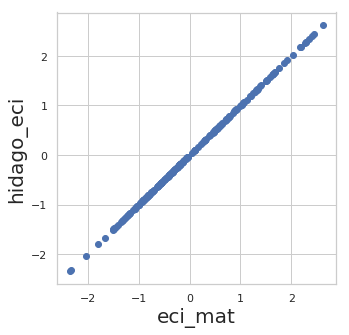

In [241]:
nl = [ "hidago_cal","hidago_eci","eci_mat","eci_sparse"]
plt.figure(figsize=(5,5))
plt.scatter(total[nl[2]],total[nl[1]])
plt.ylabel(nl[1],fontsize=20)
plt.xlabel(nl[2],fontsize=20)